In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from bmis_emg_utils import * 
from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [2]:
subjects = 5
data, label = get_emg_data(subjects)
print('The total data shape is {} and label is {}'.format(data.shape, label.shape))

The total data shape is (8, 332074) and label is (1, 332074)


In [3]:
X, y = window_with_overlap(data, label)
print('The total Input data shape after windowing is {} and label is {}'.format(X.shape, y.shape))

The total Input data shape after windowing is (83009, 8, 40) and label is (83009, 1)


In [4]:
XX_train, yy_train, XX_test, yy_test = spilt_data(X, y, ratio=0.1)
print('Training Set is{} Test Set {}'.format(XX_train.shape, XX_test.shape))

Training Set is(74708, 8, 40) Test Set (8301, 8, 40)


In [5]:
# Expanding the input feature shape

XX_train = np.expand_dims(XX_train, axis=3)
XX_test = np.expand_dims(XX_test, axis=3)
print('Expanded Dimension are {}'.format(XX_train.shape))
input_size = XX_train.shape[1:]
print(input_size)

Expanded Dimension are (74708, 8, 40, 1)
(8, 40, 1)


In [6]:
inputs = tf.keras.Input(shape=input_size)
x = tf.keras.layers.Conv2D(6, 3, activation="relu", input_shape=input_size)(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.Conv2D(16, 2, activation="relu")(x)
# emg_outputs = tf.keras.layers.MaxPooling2D((2,5))(x)
x = tf.keras.layers.MaxPooling2D((2,5))(x)
#x =  tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1500, activation='relu')(x)
x = tf.keras.layers.Dense(151, activation='relu')(x)
x = tf.keras.layers.Dense(17, activation='relu')(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="sEMG-classfier")
model.summary()

Model: "sEMG-classfier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 40, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 38, 6)          60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 36, 32)         1760      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 35, 16)         2064      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 7, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 112)            

In [7]:
lr = 0.001
opt = "nadam"#tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-07, clipnorm=1)
ls = 'sparse_categorical_crossentropy'
mtr = 'accuracy'
n_batches = 32
n_epochs = 15
model.compile(optimizer=opt, loss=ls, metrics=mtr)
K.set_value(model.optimizer.learning_rate, lr)

In [8]:
history = model.fit(XX_train, yy_train, validation_data=(XX_test, yy_test), batch_size=n_batches, epochs= n_epochs)

Epoch 1/15
2335/2335 [==============================] - 15s 6ms/step - loss: 1.4813 - accuracy: 0.3962 - val_loss: 1.0885 - val_accuracy: 0.5807
Epoch 2/15
2335/2335 [==============================] - 14s 6ms/step - loss: 0.9839 - accuracy: 0.6194 - val_loss: 0.6726 - val_accuracy: 0.7492
Epoch 3/15
2335/2335 [==============================] - 14s 6ms/step - loss: 0.7507 - accuracy: 0.7125 - val_loss: 0.5160 - val_accuracy: 0.8127
Epoch 4/15
2335/2335 [==============================] - 16s 7ms/step - loss: 0.6518 - accuracy: 0.7520 - val_loss: 0.4510 - val_accuracy: 0.8350
Epoch 5/15
2335/2335 [==============================] - 13s 6ms/step - loss: 0.5986 - accuracy: 0.7717 - val_loss: 0.4246 - val_accuracy: 0.8394
Epoch 6/15
2335/2335 [==============================] - 14s 6ms/step - loss: 0.5610 - accuracy: 0.7863 - val_loss: 0.4337 - val_accuracy: 0.8386
Epoch 7/15
2335/2335 [==============================] - 14s 6ms/step - loss: 0.5371 - accuracy: 0.7946 - val_loss: 0.3844 - val_ac

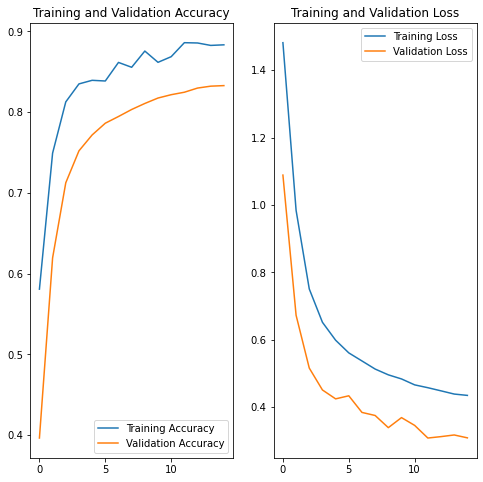

In [9]:
validation_loss = history.history['val_loss']
training_loss = history.history['loss']

validation_accuracy = history.history['accuracy']
training_accuracy = history.history['val_accuracy']

epoch_range = range(n_epochs)
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, training_accuracy, label = "Training Accuracy")
plt.plot(epoch_range, validation_accuracy, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epoch_range, training_loss, label = "Training Loss")
plt.plot(epoch_range, validation_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [10]:
saved_model = "EMG-NET-classifier.h5" 
model.save(saved_model)

4. Quantization

In [11]:
calibration_dataset = XX_train[0:1000] # Note a minumum of 100 is needed and a maximum of 1000
evaluation_dataset = XX_train[1000:]
evaluation_dataset_gnd = yy_train[1000:]

In [12]:
saved_float32_model = tf.keras.models.load_model(saved_model)
ptq_quantizer = vitis_quantize.VitisQuantizer(saved_float32_model)
ptq_quantized_model = ptq_quantizer.quantize_model(calib_dataset=calibration_dataset)

[INFO] Start CrossLayerEqualization...
10/10 [==============================] - 0s 48ms/step
[INFO] CrossLayerEqualization Done.
[INFO] Start Quantize Calibration...
20/20 [==============================] - 1s 26ms/step
[INFO] Quantize Calibration Done.
[INFO] Start Generating Quantized Model...
[Warning] Skip quantize pos adjustment for layer quant_dense, its quantize pos is [i=None, w=7.0, b=7.0, o=5.0]
[INFO] Generating Quantized Model Done.


In [13]:
ptq_quantized_model.compile(loss=ls, metrics=mtr)
ptq_quantized_model.evaluate(evaluation_dataset, evaluation_dataset_gnd)

2304/2304 [==============================] - 10s 4ms/step - loss: 0.2601 - accuracy: 0.9062


[0.260125994682312, 0.9061838388442993]

In [14]:
# Saving post training quantization

quantized_model = "qunatized-EMG-NET-classifier.h5"
ptq_quantized_model.save(quantized_model)

5. Compiling

In [15]:
!vai_c_tensorflow2 \
    --model ./qunatized-EMG-NET-classifier.h5 \
    --arch ./arch.json \
    --output_dir . \
    --net_name model

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(inputs_shape=None, layout='NHWC', model_files=['./qunatized-EMG-NET-classifier.h5'], model_type='tensorflow2', out_filename='./model_org.xmodel', proto=None)
[INFO] tensorflow2 model: qunatized-EMG-NET-classifier.h5
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/xnnc/translator/tensorflow_translator.py:1809: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  value = param.get(group).get(ds).value
[INFO] infer shape (NHWC)  :100%|█| 34/34 [00:00<00:00, 28630.06it/s]           
[OPT] No optimization method available for xir-level optimization.
[INFO] generate xmodel     :100%|█| 34/34 [00:00<00:00, 964.53it/s]             
[INFO] generate xmodel: /workspace/sEMG/sEMG_Classification/BMIS_EMG_DATA/model_org.xmodel
[UNILOG][INFO] The compiler log will be dumped at "/tmp/vitis-